In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from Aberation_cnn import *
from FFT_PSF import compute_psf, torch_apply_psf
import matplotlib.pyplot as plt
import os
from Extract_PSF import *

f:\Anaconda\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion=AberrationLossV3().to(device)


In [16]:

# 路径加载，模型路径等
model_path = ".\\best_pre_correction_models\\best_model_20251110_181112_loss0.2222.pth"  # 或 "best_pre_correction_model.pth"
model_path_1 = ".\\best_pre_correction_models_11_02\\best_model_20251031_114723_loss0.2132.pth"
model_path_2 = ".\\best_pre_correction_models_try\\best_model_20251110_220038_loss0.1263.pth" # 更换新的网络LOSS，使用的是V3
model_path_3 = ".\\best_pre_correction_models_new_model\\best_model_20251111_104052_loss0.1035.pth" # 更换新的网络架构+V3为其损失函数
test_image_path="E:\\桌面\\微信图片_20251019131600_122_386.png"
# F:\\BaiduNetdiskDownload\\COCO_2014\\val2014\\COCO_val2014_000000000502.jpg
test_image_path="F:\\BaiduNetdiskDownload\\COCO_2014\\val2014\\COCO_val2014_000000000502.jpg"
lambda_values=np.array([486,587,656])*1e-9  # 波长，单位米
# lOSS：0.4270
aberration_coeffs1 = np.array([
    [0.4548, -0.0365, 2.0154, 0.9962],  # 蓝光
    [0.4202, -0.0506, 1.6590, 0.8220],  # 绿光
    [0.3905, -0.0509, 1.4816, 0.7348]  # 红光
])
# LOSS：0.3546
aberration_coeffs = np.array([
    [0.008, -0.002, 0.010, 0.080],  # 蓝光（486nm）：[W040, W131, W222, W220]
    [0.006, -0.0015, 0.008, 0.070], # 绿光（587nm）：[W040, W131, W222, W220]
    [0.004, -0.001, 0.006, 0.060]   # 红光（656nm）：[W040, W131, W222, W220]
])
# 计算PSF

PSF1= compute_psf(lambda_values, aberration_coeffs1,g=8.48e-3,visualize=False)
PSF= compute_psf(lambda_values, aberration_coeffs,visualize=False)

PSF_zemax=extract_psf("PSF.txt",visual=False)


Loss between simulated EI image and original image: 0.4391


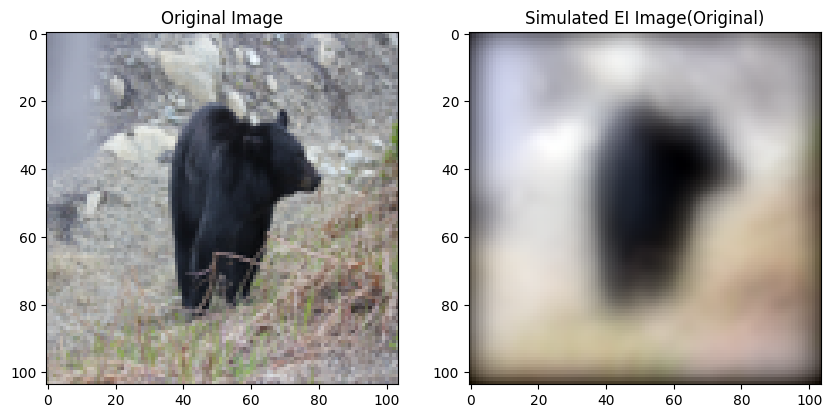

In [17]:
if os.path.exists(test_image_path):
    test_img=Image.open(test_image_path).convert('RGB').resize((104,104))
    test_array=np.array(test_img).astype(np.float32)/255.0
else:
    raise FileNotFoundError(f"Test image not found at {test_image_path}")
# 测试的原图片
test_tensor=torch.from_numpy(test_array.transpose(2,0,1)).unsqueeze(0).to(device)
# 测试的原图片转为Pytorch向量
simulated_test_image=torch_apply_psf(PSF_zemax,test_tensor)



# 对模拟成像的simulated_test_image进行处理，使其可以完成可视化
# 修正维度不匹配
if simulated_test_image.dim() == 3:  # 如果丢失批量维度，添加回去
    simulated_test_image = simulated_test_image.unsqueeze(0)
elif simulated_test_image.dim() != 4:  # 确保是 4 维张量
    raise ValueError(f"Unexpected dimension of simulated_test: {simulated_test_image.shape}")

loss=criterion(simulated_test_image,test_tensor)

# 转simulated_test_image(tensor)为numpy数组
if simulated_test_image.dim()==4: # [B,C,H,W]
    simulated_test_image=simulated_test_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0)
else:
    raise ValueError(f"Unexpected dimension of simulated_test after unsqueeze: {simulated_test_image.shape}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(test_array)
plt.subplot(1,2,2)
plt.title("Simulated EI Image(Original)")
plt.imshow(simulated_test_image)


print(f"Loss between simulated EI image and original image: {loss.item():.4f}")

Loss between simulated EI image of predicted image and original image: 0.1929


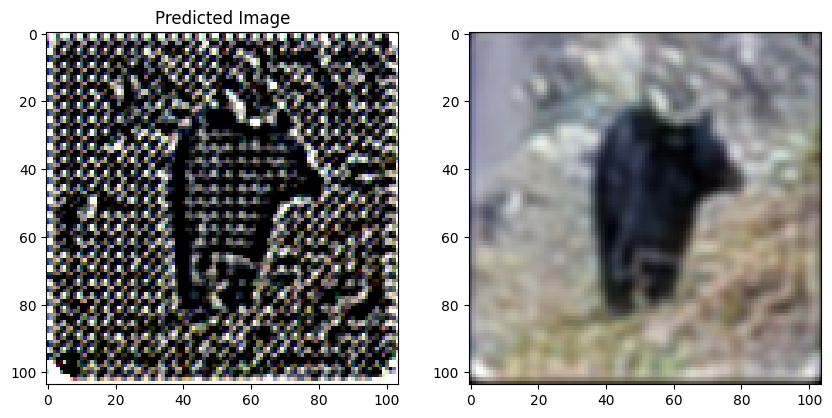

In [18]:
# 使用训练后的模型去校正EI图片
model=AberrationCNN_v3().to(device)
model.load_state_dict(torch.load(model_path_3))

# 进行推理
with torch.no_grad():
    # 注意一定要打开评估模式，否则模型校正效果极差
    model.eval()
    precorrected_image=model(test_tensor)[0]
    # print(model(test_tensor)[0])
    Simulated_procorrected_image=torch_apply_psf(PSF_zemax,precorrected_image)
    precorrected_image=precorrected_image.detach().cpu().numpy().transpose(1,2,0)

if Simulated_procorrected_image.dim() == 3:  # 如果丢失批量维度，添加回去
    Simulated_procorrected_image = Simulated_procorrected_image.unsqueeze(0)
elif Simulated_procorrected_image.dim() != 4:  # 确保是 4 维张量
    raise ValueError(f"Unexpected dimension of simulated_test: {Simulated_procorrected_image.shape}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Predicted Image")
plt.imshow(precorrected_image) 
plt.subplot(1,2,2)
plt.imshow(Simulated_procorrected_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0))
loss1=criterion(Simulated_procorrected_image,test_tensor)

print(f"Loss between simulated EI image of predicted image and original image: {loss1.item():.4f}")
